# Use sktime library to classify freezing using calcium data as input

## Load the libraries, read the dataset file and choose the between propagation (Calcium) and activity (Movement)

In [ ]:
#!pip install nbconvert

In [ ]:
import nbconvert
import pandoc

In [ ]:
#In this notebook, I employ the classifier as illustrated in the example of the documentation of the sktime library.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sktime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay
from sktime.transformations.panel.pca import PCATransformer
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.compose import ClassifierPipeline
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.kernel_based import TimeSeriesSVC
from sklearn.gaussian_process.kernels import RBF
from sktime.dists_kernels import FlatDist, ScipyDist, AggrDist
from sktime.classification.ensemble import BaggingClassifier
from sktime.classification.kernel_based import RocketClassifier
from sktime.classification.deep_learning.cnn import CNNClassifier
import json

In [ ]:
sktime.__version__

'0.29.0'

In [ ]:
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

**Define the path to the files**

In [ ]:
path='/Users/MarenLab/FP/Model/'

**Define Classifier**

In [ ]:
chosen_class = 'RFPCA'  #'KNNEU'

**Define number of neibours or estimators**

In [ ]:
num_neiorest = 2

**Choose the dataset of the animal to be analysed**

In [ ]:
cols=['Time', 'SP1', 'SP2', 'SP3', 'SP4', 'SP5', 'SP6', 'MT3', 'MT7', 'MT8']

Obs. Please note that there are several variations of the dataset.
Taking as an example the dataset of the first animal, that os, 'SP1'

(raw data just resampled) SP1_data_extinction.csv    

(derivative of the raw data above) SP1_data_extinction_der.csv

(detrended and resample raw data) SP1_data_extinction_det.csv

(The result of filtering with SG) SP1_data_extinction_sg.csv

(The derivative of the previous data) SP1_data_extinction_sg_der.csv

(detrend idea) SP1_data_extinction_sg_fl.csv

(Detrended raw data normalized as Totty did) SP1_data_extinction_zs.csv

**In the example I am using the raw data**

In [ ]:
which_col='MT8'
print(f"Reading {which_col} data")
df = pd.read_csv(path+f"{which_col}_data_extinction.csv")

Reading MT8 data


**Define the window size of a given number lags for feature extraction**

In [ ]:
window_size = 2

**Define whether propogation (Calcium) or activity (Movement) will be used as input**

There are only two choices:

'Ff'

'Movement'

In [ ]:
which_var = 'Ff'

In [ ]:
display(df)

,Times,Ff,Movement,Freezing
0,0.033333,6.399984,75,0
1,0.066667,6.369068,49,0
2,0.100000,6.337633,33,0
3,0.133333,6.305678,0,0
4,0.166667,6.273203,13,0
...,...,...,...,...
35995,1199.866676,3.950167,575,0
35996,1199.900010,4.111398,444,0
35997,1199.933343,4.273963,64,0
35998,1199.966676,4.437849,296,0


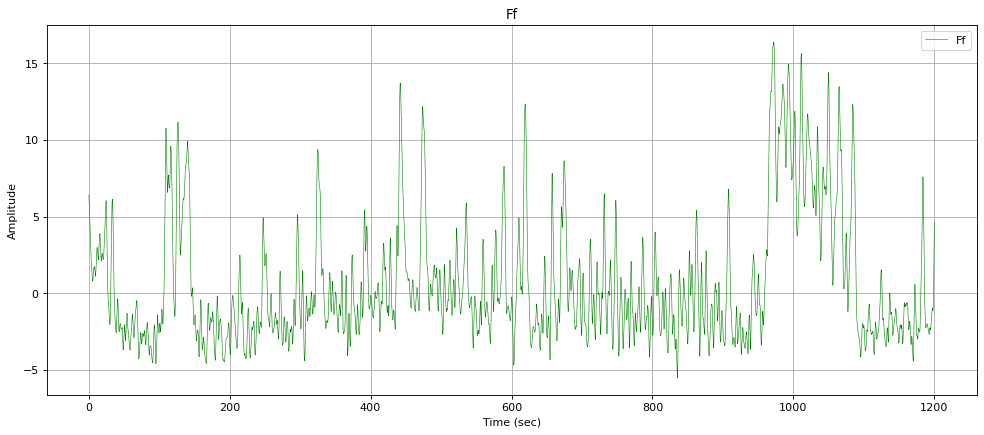

In [ ]:
plt.figure(figsize=(15, 6), dpi=80)
plt.plot(df["Times"].values,df[which_var].values, label=which_var, color='green', lw=0.5)
plt.ylabel("Amplitude")
plt.xlabel("Time (sec)")
plt.title(which_var)
plt.legend()
plt.grid()
pass

In [ ]:
[min(df[which_var].values),max(df[which_var].values)]

[-5.54993852420948, 16.402541644256896]

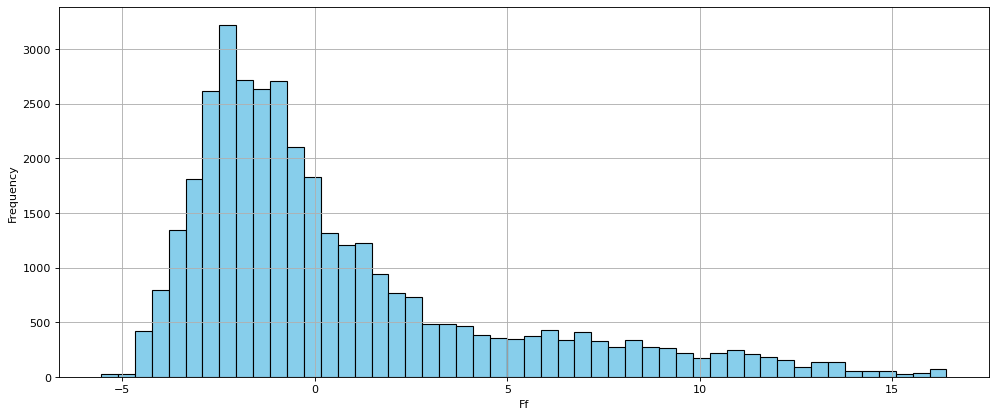

In [ ]:
plt.figure(figsize=(15, 6), dpi=80)
plt.hist(df[which_var].values, bins=50, color='skyblue', edgecolor='black')
plt.ylabel("Frequency")
plt.xlabel(f"{which_var}")
#plt.title(f"{which_var}")
#plt.legend()
plt.grid()
pass

In [ ]:
# Build time array
timeEst=df["Times"].values
display(timeEst)

array([3.33333330e-02, 6.66666670e-02, 1.00000000e-01, ...,
       1.19993334e+03, 1.19996668e+03, 1.20000001e+03])

In [ ]:
# Store the number of data points
n_samples  = len(df)
print(f'Number of data points: {n_samples}')

Number of data points: 36000


In [ ]:
# Based on the window size  find the number of samples to be used
n_samples = n_samples - window_size + 1

# Creating nested DataFrame for sktime
X_nested = pd.DataFrame(index=np.arange(n_samples), columns=[which_var])
for i in range(n_samples):
    X_nested.iloc[i, 0] = pd.Series(df[which_var].iloc[i:i+window_size].values)

y_nested = df['Freezing'].iloc[window_size-1:]

print(f'\nNumber of rows of X_nested = {X_nested.shape[0]}')
print(f'\nNumber of rows of y_nested = {y_nested.shape[0]}\n')
display(X_nested)


Number of rows of X_nested = 35999

Number of rows of y_nested = 35999



,Ff
0,0 6.399984 1 6.369068 dtype: float64
1,0 6.369068 1 6.337633 dtype: float64
2,0 6.337633 1 6.305678 dtype: float64
3,0 6.305678 1 6.273203 dtype: float64
4,0 6.273203 1 6.240209 dtype: float64
...,...
35994,0 3.790290 1 3.950167 dtype: float64
35995,0 3.950167 1 4.111398 dtype: float64
35996,0 4.111398 1 4.273963 dtype: float64
35997,0 4.273963 1 4.437849 dtype: float64


In [ ]:
# Splitting the data
split_point = int(n_samples * 0.8)
X_train, X_test = X_nested.iloc[:split_point], X_nested.iloc[split_point:]
y_train, y_test = y_nested.iloc[:split_point], y_nested.iloc[split_point:]
t_train = timeEst[:split_point]
t_test = timeEst[(split_point+window_size-1):]
print(f'{split_point} will be used for training and {n_samples-split_point+1} for training')

28799 will be used for training and 7201 for training


In [ ]:
display(X_train)

,Ff
0,0 6.399984 1 6.369068 dtype: float64
1,0 6.369068 1 6.337633 dtype: float64
2,0 6.337633 1 6.305678 dtype: float64
3,0 6.305678 1 6.273203 dtype: float64
4,0 6.273203 1 6.240209 dtype: float64
...,...
28794,0 0.760864 1 0.798303 dtype: float64
28795,0 0.798303 1 0.836619 dtype: float64
28796,0 0.836619 1 0.875916 dtype: float64
28797,0 0.875916 1 0.916282 dtype: float64


In [ ]:
if chosen_class == 'KN':
    print('General KNN algorithm was chosen')
    pipeline = ClassifierPipeline(TimeSeriesForestClassifier(n_estimators=num_neiorest), [PCATransformer()])
elif chosen_class == 'RFPCA':
    print('RandonForest with PCA was chosen')
    pipeline = ClassifierPipeline(TimeSeriesForestClassifier(n_estimators=num_neiorest), [PCATransformer()])
elif chosen_class == 'RF':
    print('General RandonForest was chosen')
    pipeline = TimeSeriesForestClassifier(n_estimators=num_neiorest)
elif chosen_class == 'SVC':
    print('Support Vector Classifier was chosen')
    mean_gaussian_tskernel = AggrDist(RBF())
    pipeline = TimeSeriesSVC(kernel=mean_gaussian_tskernel)
elif chosen_class == 'BG':
    print('Bagging Classifier was chosen')
    pipeline = BaggingClassifier(RocketClassifier(num_kernels=10),n_estimators=num_neiorest,)
elif chosen_class == 'CNN':
    print(' time series classification by deep learning')
    pipeline=CNNClassifier(n_epochs=20,batch_size=4)
else:
    print('Euclidean distance KN')
    eucl_dist = FlatDist(ScipyDist())
    pipeline = KNeighborsTimeSeriesClassifier(n_neighbors=num_neiorest, distance=eucl_dist)
#
display(pipeline)



RandonForest with PCA was chosen


ClassifierPipeline(classifier=TimeSeriesForestClassifier(n_estimators=2),
                   transformers=[PCATransformer()])

In [ ]:
#pipeline.get_params()

In [ ]:
# Fit the model
pipeline.fit(X_train, y_train)

ClassifierPipeline(classifier=TimeSeriesForestClassifier(n_estimators=2),
                   transformers=[PCATransformer()])

In [ ]:
# Predict over the train data
y_est = pipeline.predict(X_train)

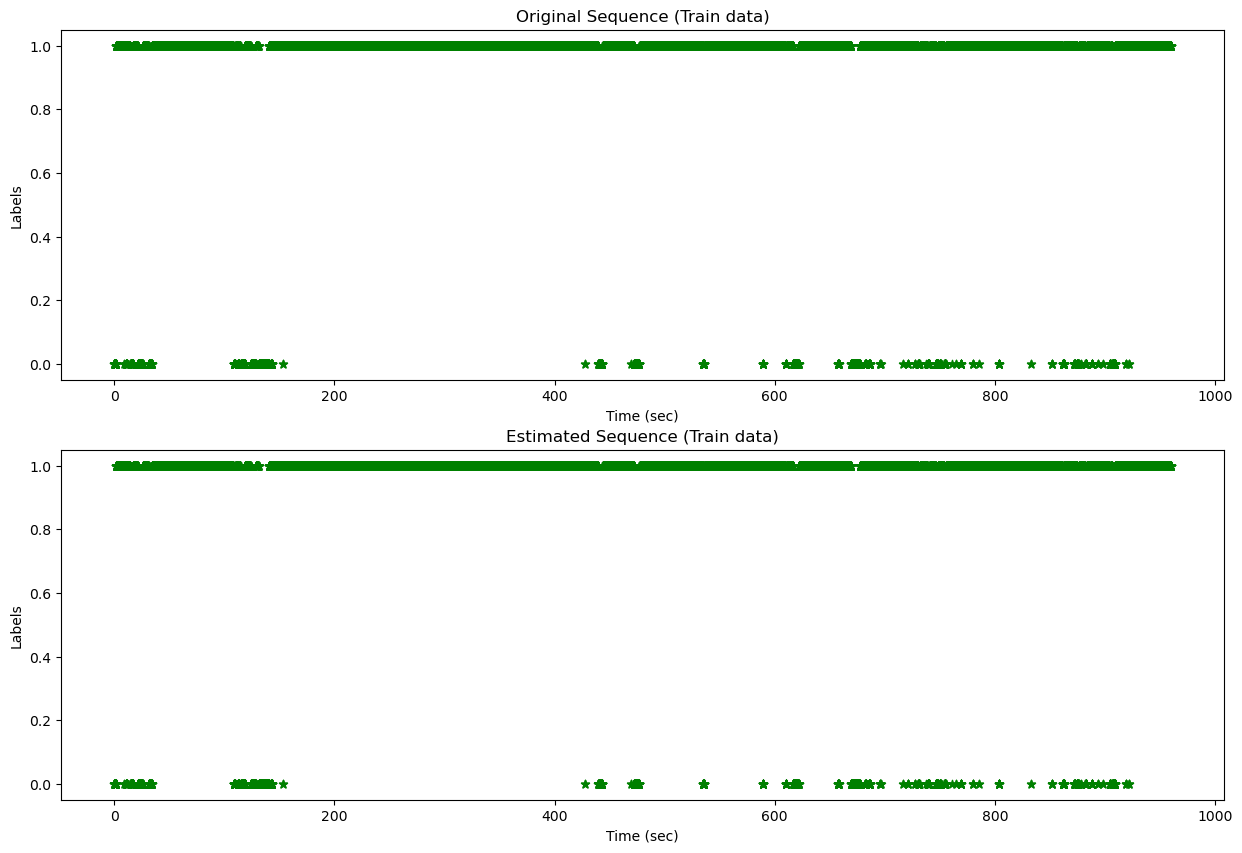

In [ ]:
plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
plt.scatter(t_train,y_train, label='Freezing', color='green', marker='*')
plt.ylabel("Labels")
plt.xlabel("Time (sec)")
plt.title("Original Sequence (Train data)")
#plt.legend()
plt.subplot(2,1,2)
plt.scatter(t_train,y_est, label='Freezing', color='green', marker='*')
plt.ylabel("Labels")
plt.xlabel("Time (sec)")
plt.title("Estimated Sequence (Train data)")
#plt.legend()
plt.show()

In [ ]:
pipeline.predict_proba(X_test)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [ ]:
# Accuracy on the train data

accuracy_train = accuracy_score(y_train, y_est)
print(f'Accuracy on the train data: {accuracy_train}')

# Generate confusion matrix
conf_matrix_train = confusion_matrix(y_train, y_est)

print("\nConfusion Matrix:\n", conf_matrix_train)

# Detailed classification report
class_report_train = classification_report(y_train, y_est)
print("\nClassification Report:\n", class_report_train)

Accuracy on the train data: 1.0

Confusion Matrix:
 [[ 2340     0]
 [    0 26459]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2340
           1       1.00      1.00      1.00     26459

    accuracy                           1.00     28799
   macro avg       1.00      1.00      1.00     28799
weighted avg       1.00      1.00      1.00     28799



## In what follows, we will observe how the classification model performs on a test dataset, which is unknown to the model.

In [ ]:
# Predict over the data data
y_pred = pipeline.predict(X_test)

In [ ]:
# Accuracy on the test data

accuracy_test = accuracy_score(y_test, y_pred)
print(f'Accuracy on the test data: {accuracy_test}')

# Generate confusion matrix
conf_matrix_test = confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix:\n", conf_matrix_test)

# Detailed classification report
class_report_test = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report_test)

Accuracy on the test data: 0.8722222222222222

Confusion Matrix:
 [[2524  774]
 [ 146 3756]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.77      0.85      3298
           1       0.83      0.96      0.89      3902

    accuracy                           0.87      7200
   macro avg       0.89      0.86      0.87      7200
weighted avg       0.88      0.87      0.87      7200



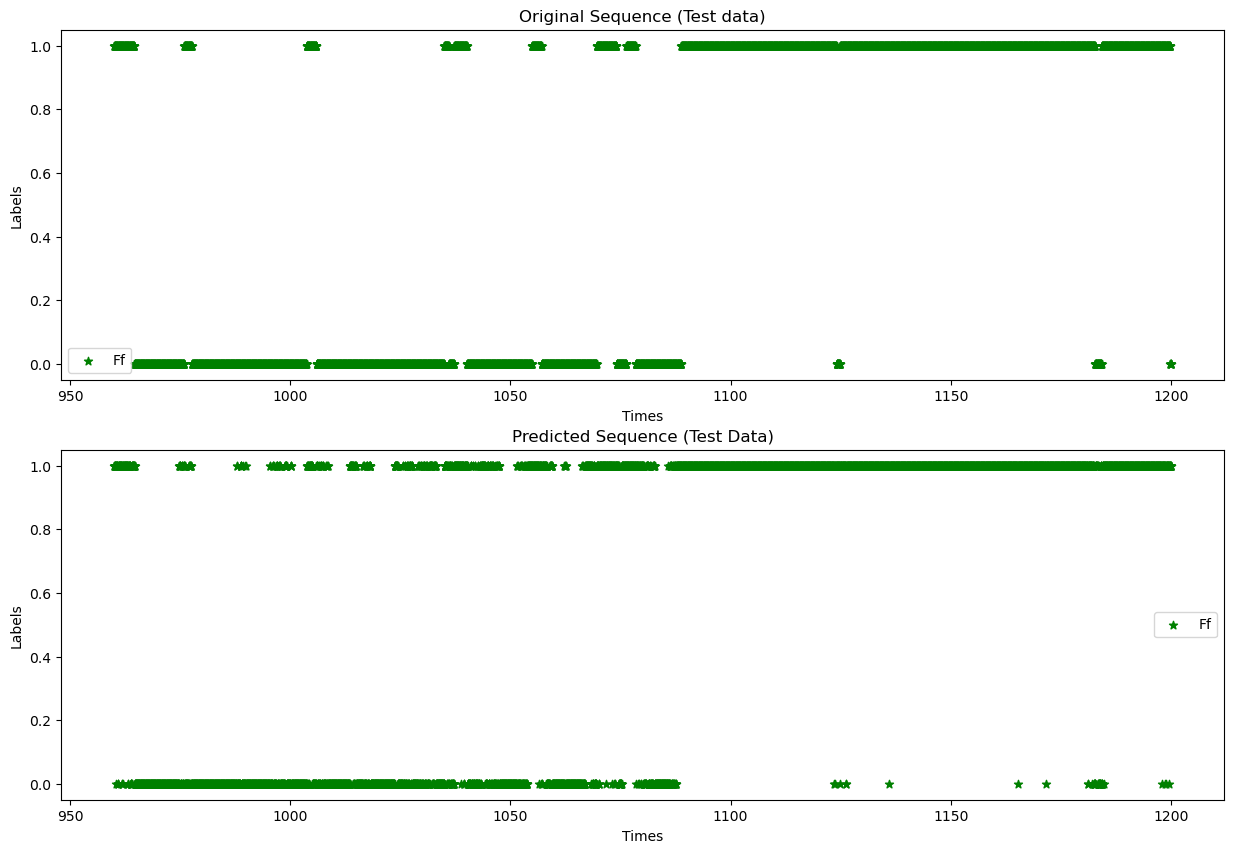

In [ ]:
plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
plt.scatter(t_test,y_test, label='Ff', color='green', marker='*')
plt.ylabel("Labels")
plt.xlabel("Times")
plt.title("Original Sequence (Test data)")
plt.legend()
plt.subplot(2,1,2)
plt.scatter(t_test,y_pred, label='Ff', color='green', marker='*')
plt.ylabel("Labels")
plt.xlabel("Times")
plt.title("Predicted Sequence (Test Data)")
plt.legend()
plt.show()

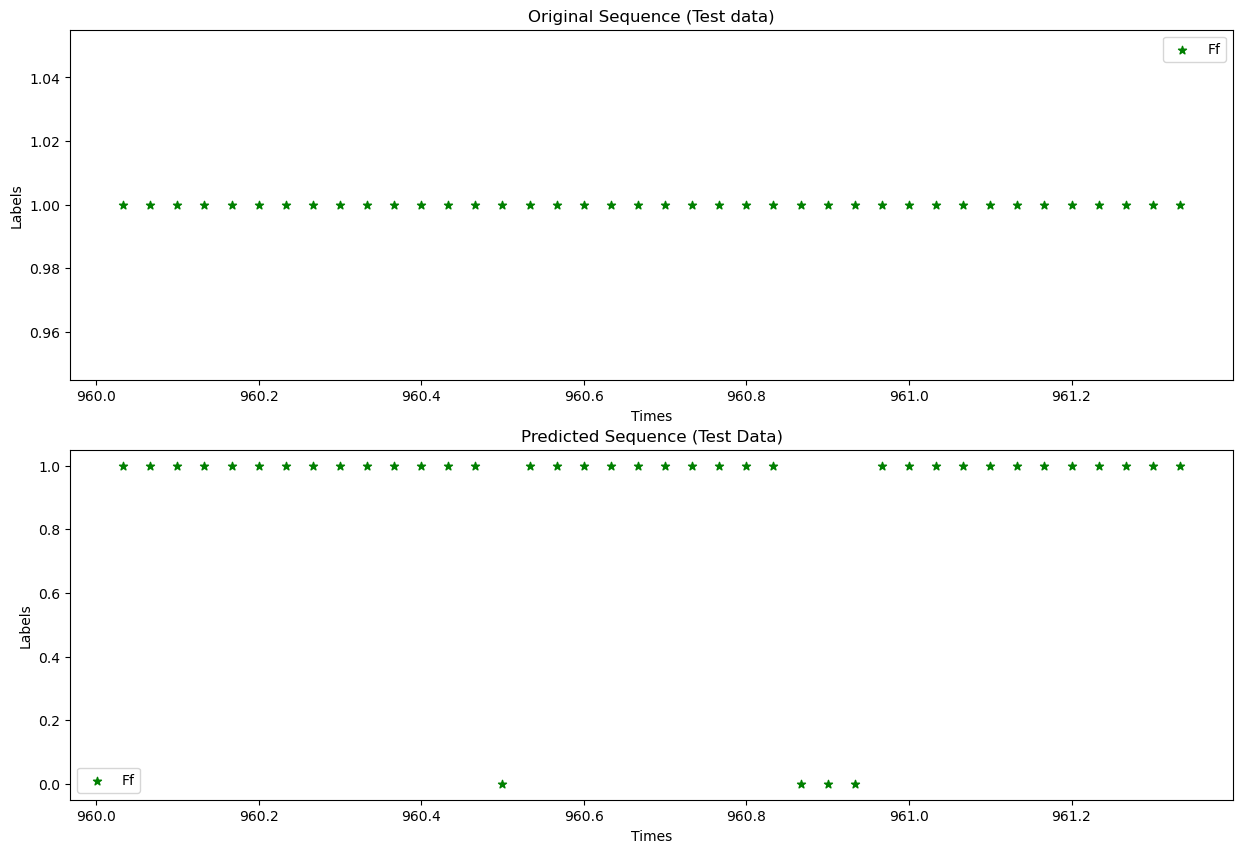

In [ ]:
leng=40
plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
plt.scatter(t_test[:leng],y_test[:leng], label='Ff', color='green', marker='*')
plt.ylabel("Labels")
plt.xlabel("Times")
plt.title("Original Sequence (Test data)")
plt.legend()
plt.subplot(2,1,2)
plt.scatter(t_test[:leng],y_pred[:leng], label='Ff', color='green', marker='*')
plt.ylabel("Labels")
plt.xlabel("Times")
plt.title("Predicted Sequence (Test Data)")
plt.legend()
plt.show()

## Below, we will examine the estimates of freezing as indicated by color changes in the movement data and compare them to the actual freezing observed in the same dataset.

### First - Using train data

In [ ]:
states = pd.unique(y_train)
print("Unique states:")
print(states)

Unique states:
[0 1]


#### Using the entire dataset used for training the model.

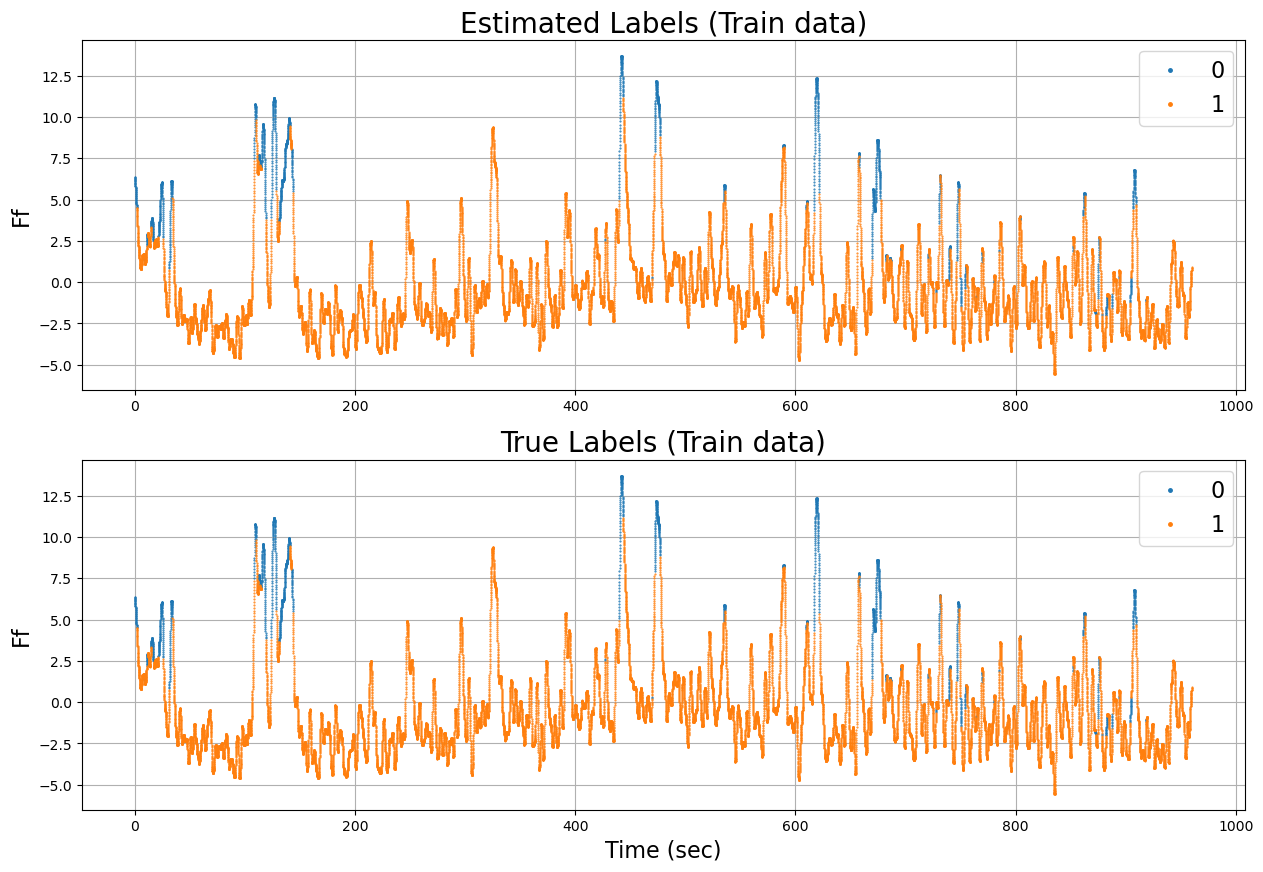

In [ ]:
plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
for i in states:
    want = (y_est == i)
    x = t_train[want]
    y = ((df[which_var].iloc[:split_point].values))[want]
    plt.plot(x, y, '.', markersize = 1)
plt.legend(states, fontsize=16, loc='upper right', markerscale=5.)
plt.grid(True)
#plt.xlabel("Time (sec)", fontsize=16)
plt.ylabel(f'{which_var}', fontsize=16)
plt.title("Estimated Labels (Train data)",fontsize=20)
plt.subplot(2,1,2)
for i in states:
    want = (y_est == i)
    x = t_train[want]
    y = ((df[which_var].iloc[:split_point].values))[want]
    plt.plot(x, y, '.', markersize = 1)
plt.legend(states, fontsize=16, loc='upper right', markerscale=5.)
plt.grid(True)
plt.xlabel("Time (sec)", fontsize=16)
plt.ylabel(f'{which_var}', fontsize=16)
plt.title("True Labels (Train data)",fontsize=20)
plt.show()

#### Zoom over a chosen data range

In [ ]:
ileng=6000
fleng=7000
fleng=min(fleng,len(t_train))
ileng=min(ileng,fleng-10)
display(ileng)
display(fleng)

6000

7000

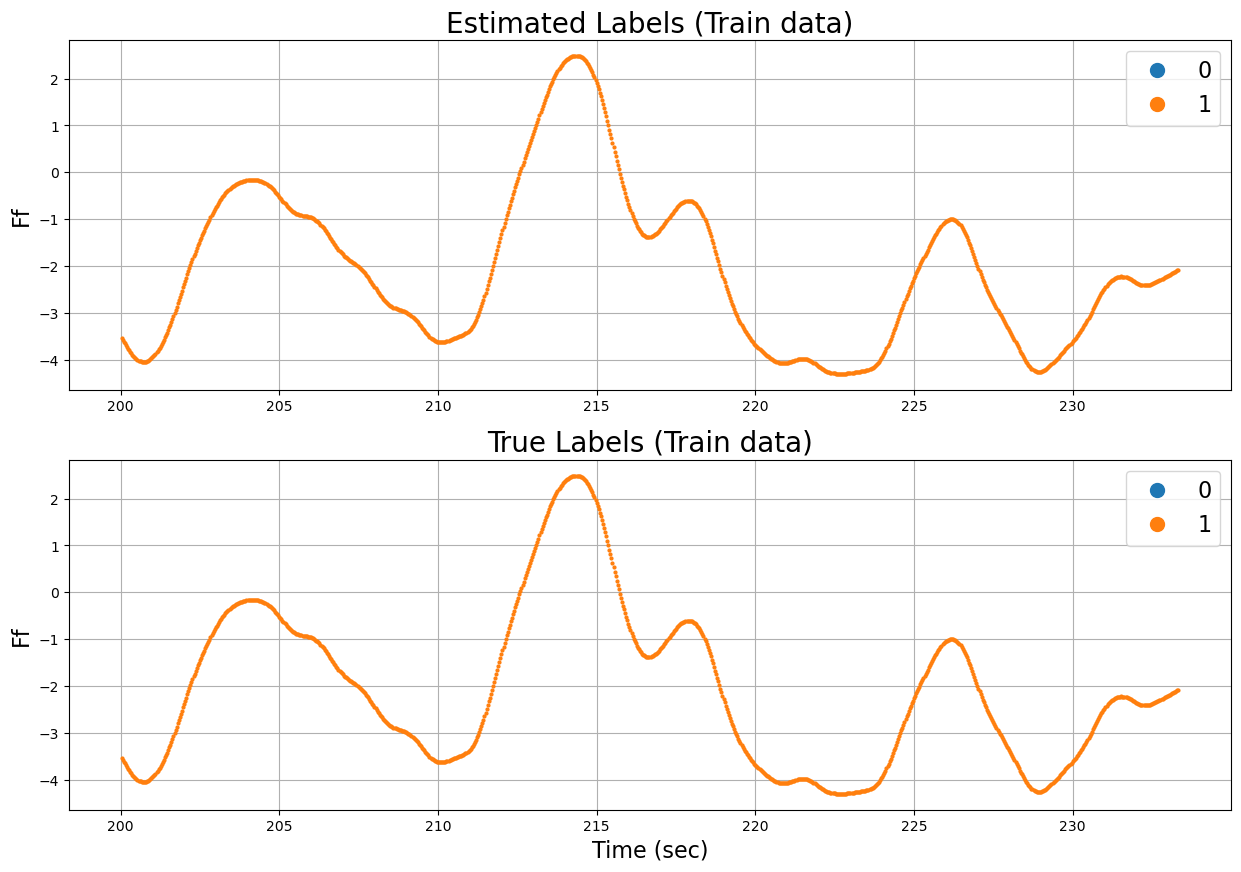

In [ ]:
plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
for i in states:
    want = (y_est[ileng:fleng] == i)
    x = t_train[ileng:fleng][want]
    y = ((df[which_var].iloc[:split_point].values)[ileng:fleng])[want]
    plt.plot(x, y, '.', markersize = 4)
plt.legend(states, fontsize=16, loc='upper right', markerscale=5.)
plt.grid(True)
#plt.xlabel("Time (sec)", fontsize=16)
plt.ylabel(f'{which_var}', fontsize=16)
plt.title("Estimated Labels (Train data)",fontsize=20)
plt.subplot(2,1,2)
for i in states:
    want = (y_train[ileng:fleng] == i)
    x = t_train[ileng:fleng][want]
    y = ((df[which_var].iloc[:split_point].values)[ileng:fleng])[want]
    plt.plot(x, y, '.', markersize = 4)
plt.legend(states, fontsize=16, loc='upper right', markerscale=5.)
plt.grid(True)
plt.xlabel("Time (sec)", fontsize=16)
plt.ylabel(f'{which_var}', fontsize=16)
plt.title("True Labels (Train data)",fontsize=20)
plt.show()

### Now using the test data

In [ ]:
states = pd.unique(y_test)
print("Unique states:")
print(states)

Unique states:
[1 0]


#### Using the entire dataset used for testing the model.

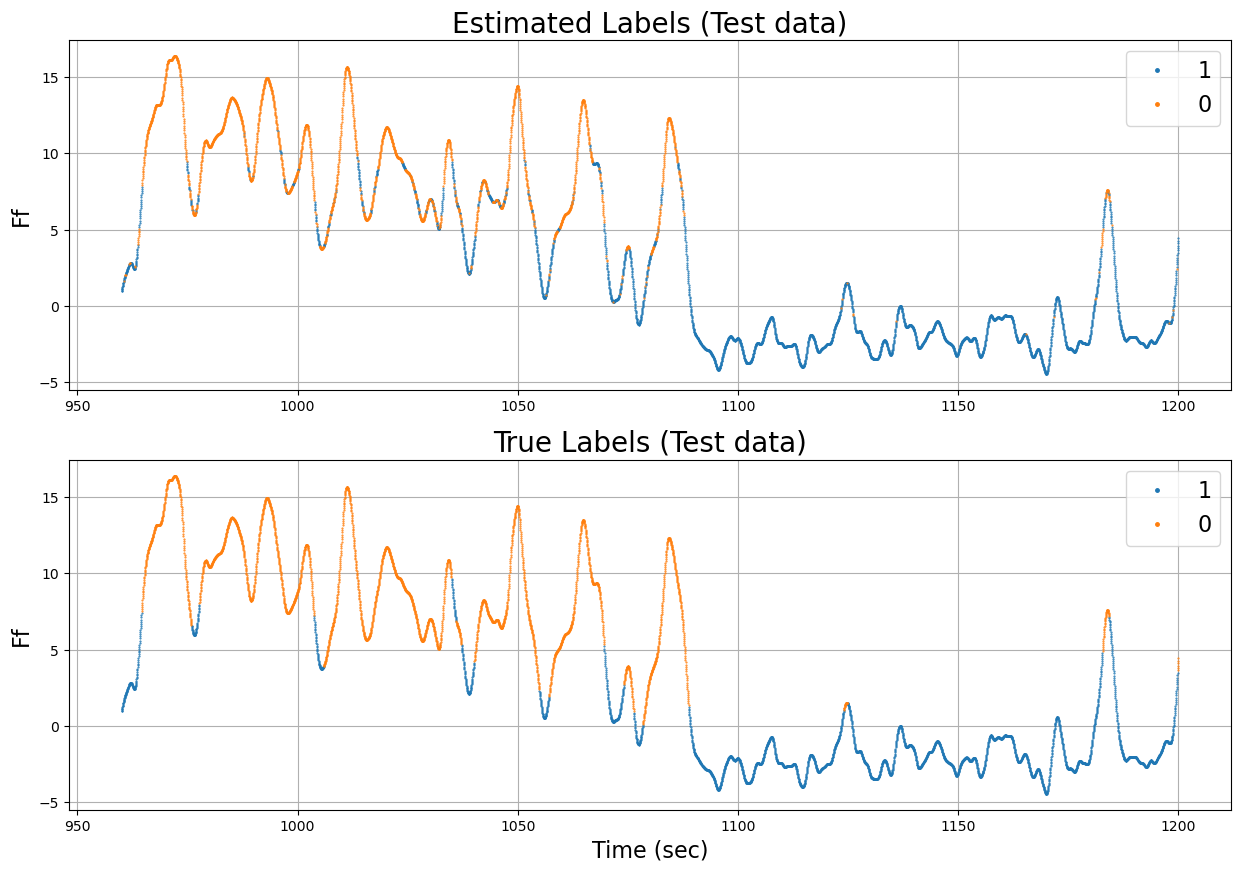

In [ ]:
plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
temp = ((df[which_var].iloc[split_point:n_samples].values))
for i in states:
    want = (y_pred == i)
    x = t_test[want]
    y = temp[want]
    plt.plot(x, y, '.', markersize = 1)
plt.legend(states, fontsize=16, loc='upper right', markerscale=5.)
plt.grid(True)
#plt.xlabel("Time (sec)", fontsize=16)
plt.ylabel(f'{which_var}', fontsize=16)
plt.title("Estimated Labels (Test data)",fontsize=20)
plt.subplot(2,1,2)
for i in states:
    want = (y_test == i)
    x = t_test[want]
    y = temp[want]
    plt.plot(x, y, '.', markersize = 1)
plt.legend(states, fontsize=16, loc='upper right', markerscale=5.)
plt.grid(True)
plt.xlabel("Time (sec)", fontsize=16)
plt.ylabel(f'{which_var}', fontsize=16)
plt.title("True Labels (Test data)",fontsize=20)
plt.show()

#### Zoom over the chosen data range

In [ ]:
ileng=5000
fleng=6000
fleng=min(fleng,len(t_test))
ileng=min(ileng,fleng-10)
display(ileng)
display(fleng)

5000

6000

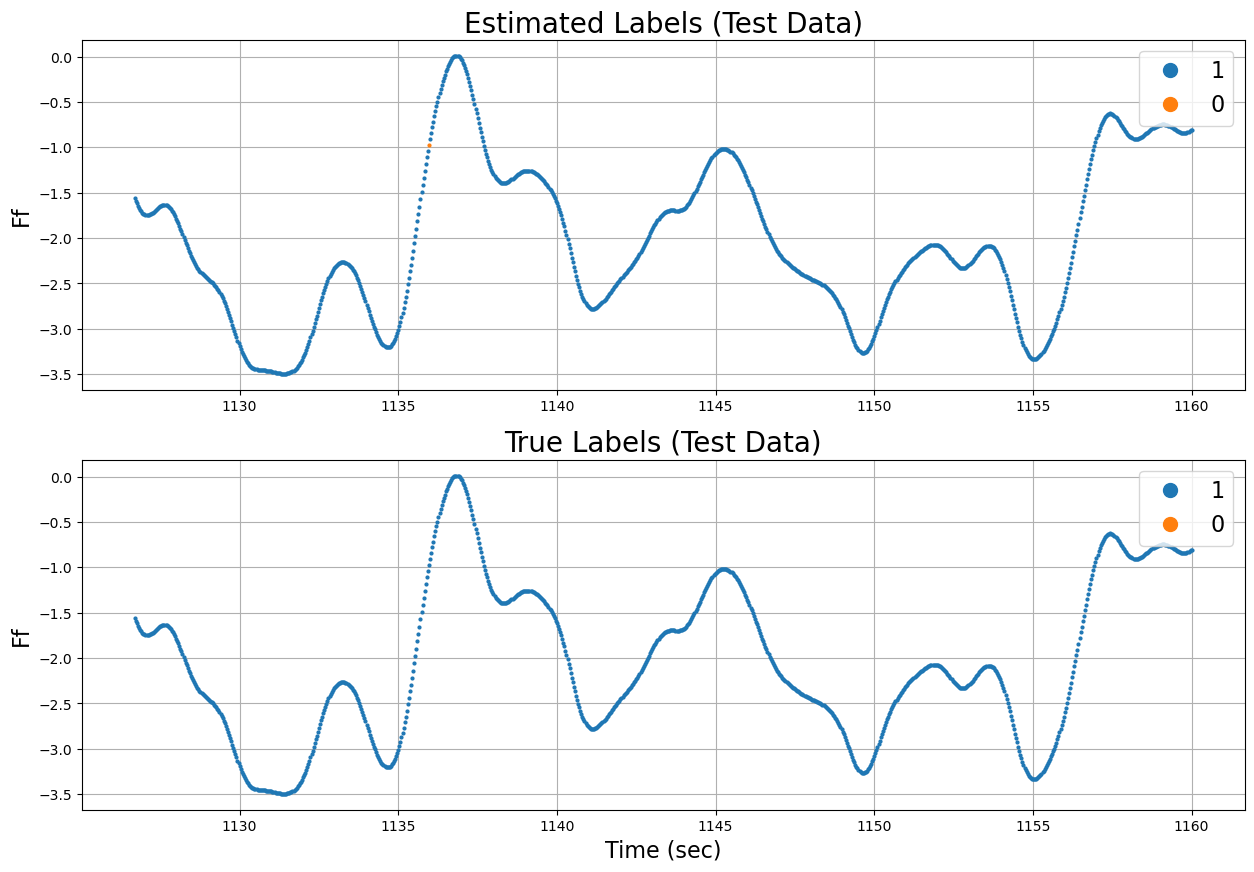

In [ ]:
plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
for i in states:
    want = (y_pred[ileng:fleng] == i)
    x = t_test[ileng:fleng][want]
    y = temp[ileng:fleng][want]
    plt.plot(x, y, '.', markersize = 4)
plt.legend(states, fontsize=16, loc='upper right', markerscale=5.)
plt.grid(True)
#plt.xlabel("Time (sec)", fontsize=16)
plt.ylabel(f'{which_var}', fontsize=16)
plt.title("Estimated Labels (Test Data)",fontsize=20)
plt.subplot(2,1,2)
for i in states:
    want = (y_test[ileng:fleng] == i)
    x = t_test[ileng:fleng][want]
    y = temp[ileng:fleng][want]
    plt.plot(x, y, '.', markersize = 4)
plt.legend(states, fontsize=16, loc='upper right', markerscale=5.)
plt.grid(True)
plt.xlabel("Time (sec)", fontsize=16)
plt.ylabel(f'{which_var}', fontsize=16)
plt.title("True Labels (Test Data)",fontsize=20)
plt.show()

## Display accuracy and other measures again

In [ ]:
print(f'\nResults obtained by using a classification algorithm\n')
print(f'Animal: {which_col}\n')
print(f'Window size: {window_size}\n')
print(f'Variable used as input: {which_var}\n')
print('Train Data\n')
print(f'Accuracy on the test data: {accuracy_train}')
print("\nConfusion Matrix:\n", conf_matrix_train)
print("\nClassification Report:\n\n", class_report_train)
print('Test Data\n')
print(f'Accuracy on the test data: {accuracy_test}')
print("\nConfusion Matrix:\n", conf_matrix_test)
print("\nClassification Report:\n", class_report_test)


Results obtained by using a classification algorithm

Animal: MT8

Window size: 2

Variable used as input: Ff

Train Data

Accuracy on the test data: 1.0

Confusion Matrix:
 [[ 2340     0]
 [    0 26459]]

Classification Report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2340
           1       1.00      1.00      1.00     26459

    accuracy                           1.00     28799
   macro avg       1.00      1.00      1.00     28799
weighted avg       1.00      1.00      1.00     28799

Test Data

Accuracy on the test data: 0.8722222222222222

Confusion Matrix:
 [[2524  774]
 [ 146 3756]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.77      0.85      3298
           1       0.83      0.96      0.89      3902

    accuracy                           0.87      7200
   macro avg       0.89      0.86      0.87      7200
weighted avg       0.88      0.87      0

## Save scores for later use

In [ ]:
data={'Accuracy': accuracy_train, 'Confusion Matrix': conf_matrix_train, 'Classification Report': class_report_train}

In [ ]:
#exec(f'Metric_{which_col}_train=data')

In [ ]:
#np.savez(f'{path}Results_{chosen_class}_{which_col}_train.npz', **data)

In [ ]:
data={'Accuracy': accuracy_test, 'Confusion Matrix': conf_matrix_test, 'Classification Report': class_report_test}

In [ ]:
#exec(f'Metric_{which_col}_test=data')

In [ ]:
#np.savez(f'{path}Results_{chosen_class}_{which_col}_test.npz', **data)